In [1]:
from mudpy import forward
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from obspy.geodetics import degrees2kilometers, gps2dist_azimuth

In [2]:
path = '/Users/sydneydybing/SW4/strain/'
out_path = path + 'experiments/'

In [3]:
usgs_ff_model = np.genfromtxt(path + 'usgsRC.rupt') # from basic_inversion.param
print(usgs_ff_model)

[[ 1.000000e+00 -1.181944e+02  3.632840e+01 ...  2.230000e+03
   3.340000e+01  0.000000e+00]
 [ 2.000000e+00 -1.181580e+02  3.629440e+01 ...  2.230000e+03
   3.120000e+01  0.000000e+00]
 [ 3.000000e+00 -1.181216e+02  3.626050e+01 ...  2.230000e+03
   2.900000e+01  0.000000e+00]
 ...
 [ 3.340000e+02 -1.173028e+02  3.546680e+01 ...  2.230000e+03
   2.100000e+01  0.000000e+00]
 [ 3.350000e+02 -1.172664e+02  3.543280e+01 ...  2.230000e+03
   2.260000e+01  0.000000e+00]
 [ 3.360000e+02 -1.172300e+02  3.539890e+01 ...  2.230000e+03
   2.400000e+01  0.000000e+00]]


In [4]:
lons = usgs_ff_model[:,1]
lats = usgs_ff_model[:,2]
depths = usgs_ff_model[:,3]

lon_midpoint = min(lons) + (max(lons) - min(lons))/2
lat_midpoint = min(lats) + (max(lats) - min(lats))/2
depth_midpoint = min(depths) + (max(depths) - min(depths))/2

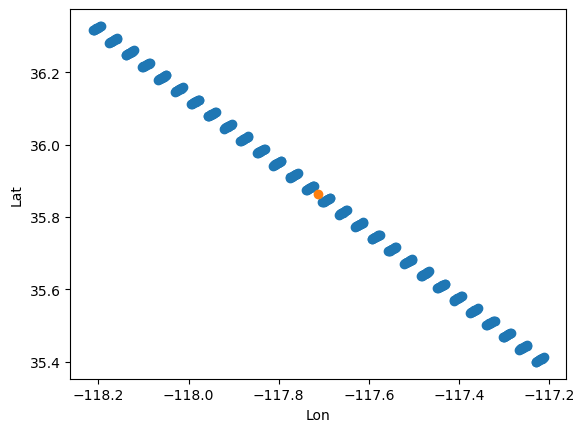

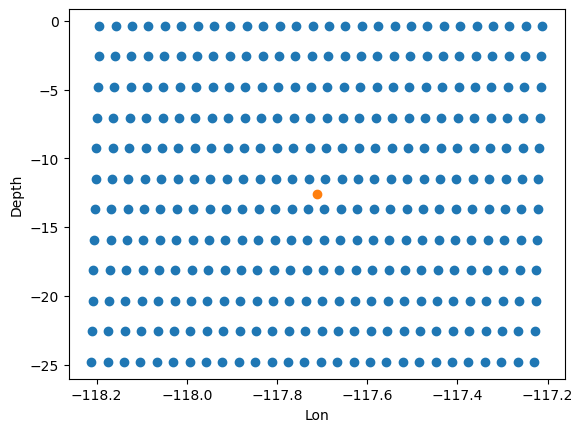

In [5]:
plt.scatter(lons, lats)
plt.scatter(lon_midpoint, lat_midpoint)
# plt.scatter(epi_lon, epi_lat)
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.show()

plt.scatter(lons, -depths)
plt.scatter(lon_midpoint, -depth_midpoint)
plt.xlabel('Lon')
plt.ylabel('Depth')
plt.show();

In [8]:
rupt_params = np.load(path + 'experiments/realistic_eq_sizes/rupture_params.npy')
print(rupt_params)

# 0. Mw
# 1. Length (km)
# 2. Average slip (m)
# 3. Rise time (s)

# Using 15km average seisomogenic depth from 
# https://pubs.geoscienceworld.org/ssa/bssa/article/94/3/940/103113/The-Seismogenic-Thickness-of-the-Southern

[[5.00000000e+00 3.38844156e+00 1.51356125e-02 3.35853594e-01]
 [6.00000000e+00 1.41253754e+01 1.20226443e-01 9.23953255e-01]
 [7.00000000e+00 5.88843655e+01 9.54992586e-01 2.54185048e+00]
 [8.00000000e+00 2.45470892e+02 7.58577575e+00 6.99278217e+00]]


In [42]:
# Ridgecrest epicenter from USGS FF model

epi_lon = -117.6204 
epi_lat = 35.7793
hypo_depth = 7.5 # just half of 15
strike = 139
dip = 90
epicenter = [epi_lon, epi_lat, hypo_depth]
print(epicenter)

[-117.6204, 35.7793, 7.5]


Mw: 5.0


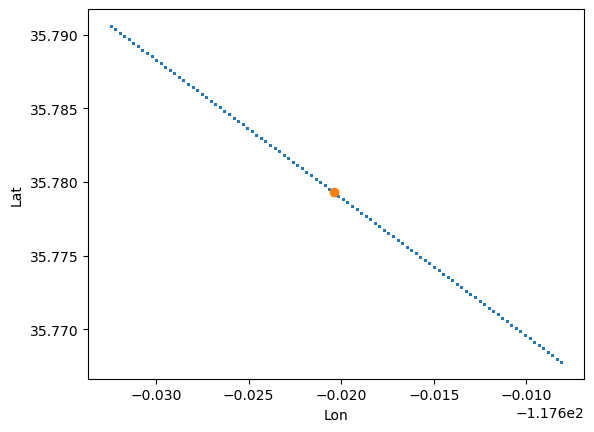

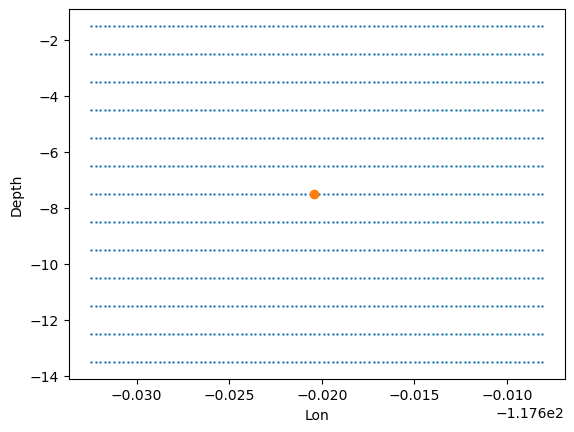

Mw: 6.0


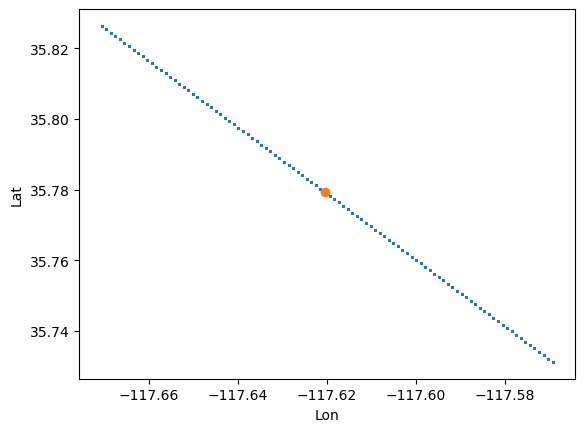

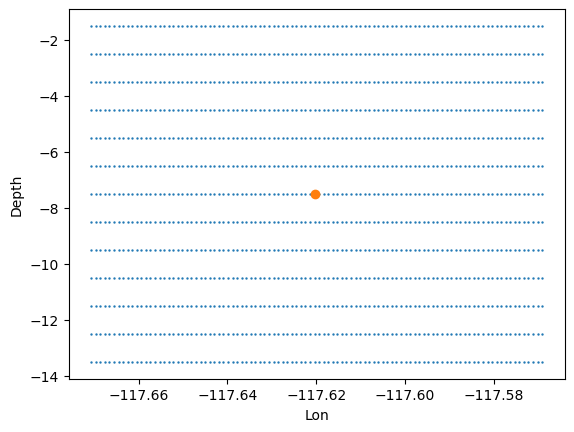

Mw: 7.0


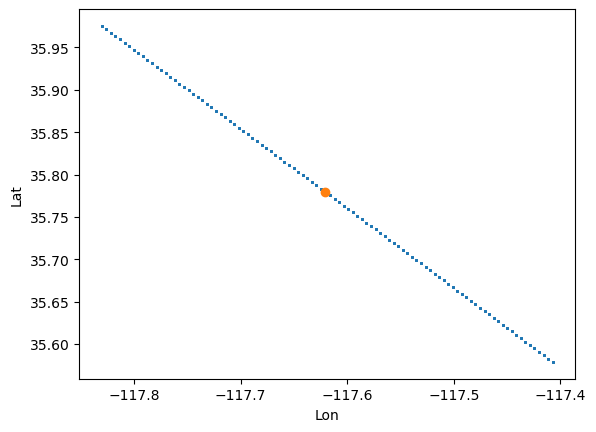

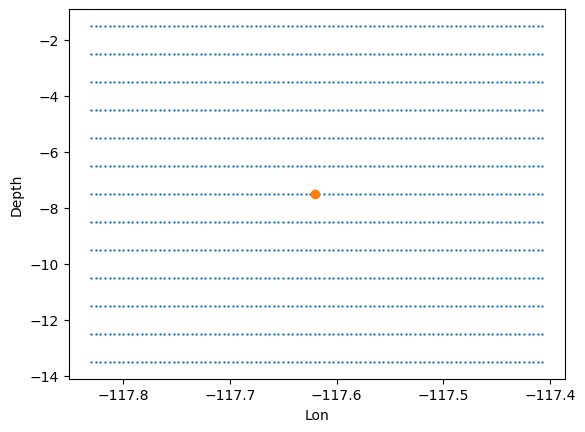

Mw: 8.0


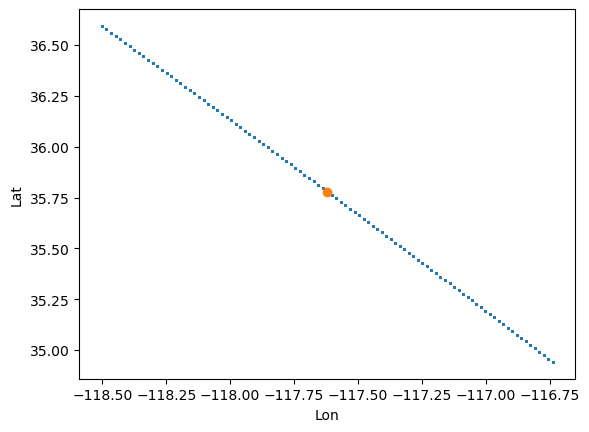

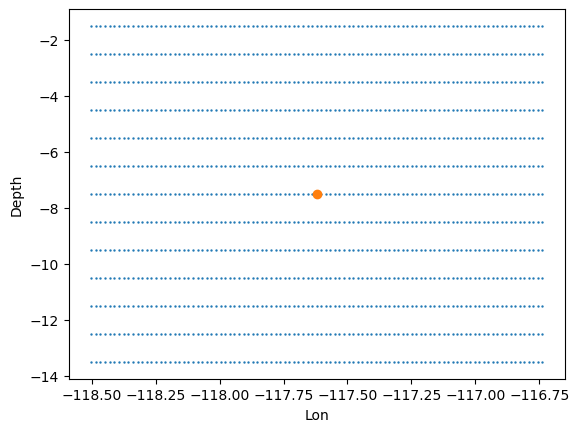

In [46]:
for i in range(len(rupt_params)):
    
    Mw = rupt_params[i,0]
    print('Mw: ' + str(Mw))
    fault_len = rupt_params[i,1]
    # print('Fault length (km): ' + str(round(fault_len,2)))
    fault_depth = hypo_depth * 2
    # print('Fault depth (km): ' + str(fault_depth))
    # Let's do subfault every len/10 km strike
    dx_strike = fault_len/100 # km
    # print('Subfaults every ' + str(round(dx_strike,3)) + ' km along-strike')
    nstrike = int(round(fault_len/dx_strike))
    # print('Total of ' + str(nstrike) + ' subfaults along-strike')
    # And a subfault every 0.5 km dip
    dx_dip = 1
    ndip = int(fault_depth/dx_dip)
    num_updip = int(ndip / 2)-1
    num_downdip = num_updip
    rise_time = rupt_params[i,3]
    # print('Rise time (s): ' + str(round(rise_time,2)))
    
    # Make fault
    fout = out_path + 'realistic_eq_sizes/M' + str(int(Mw)) + '.fault'
    forward.makefault(fout,strike,dip,nstrike,dx_dip,dx_strike,epicenter,num_updip,num_downdip,rise_time)

    # Check how it looks

    new_fault = np.genfromtxt(fout)

    new_lons = new_fault[:,1]
    new_lats = new_fault[:,2]
    new_depths = new_fault[:,3]

    plt.scatter(new_lons, new_lats, s = 0.5)
    plt.scatter(epi_lon, epi_lat)
    # plt.scatter(epi_lon, epi_lat)
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.show()

    plt.scatter(new_lons, -new_depths, s = 0.5)
    plt.scatter(epi_lon, -hypo_depth)
    plt.xlabel('Lon')
    plt.ylabel('Depth')
    plt.show();
    
    # Because we defined the fault by the hypocenter, there is a subfault exactly there in every fault
    # So the epicenter in the previous cell is the one to use for force_hypocenter